# Combine bias images to make master


The final step is to combine the individual calibrated bias images into a single
combined image. That combined image will have less noise than the individual
images, minimizing the noise added to the remaining images when the bias is
subtracted.

Regardless of which path you took through the calibration of the biases (with
overscan or without), there should be a folder named `reduced` that contains the
calibrated bias images. If there is not, please run the previous notebook before
continuing with this one.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Recommended settings for image combination

As discussed in the [notebook about combining images](01-06-Image-combination.ipynb), the recommendation is
that you combine by averaging the individual images but sigma clip to remove
extreme values.

[ccdproc](https://ccdproc.readthedocs.org) provides two ways to combine:

+ An object-oriented interface built around the `Combiner` object, described in
the [ccdproc documentation on image combination](https://ccdproc.readthedocs.io/en/latest/image_combination.html).
+ A function called [`combine`](https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html#ccdproc.combine), which we will use here because the function
allows you to specify the maximum amount of memory that should be used during
combination. This feature can be essential depending on how many images you need
to combine, how big they are, and how much memory your computer has.

*NOTE: If using a version of ccdproc lower than 2.0, set the memory limit a
factor of 2-3 lower than you want the maximum memory consumption to be.*

## Example 1: Cryogenically-cooled camera

The remainder of this section assumes the calibrated bias images are in the
folder `example1-reduced` which is created in the previous notebook.

In [3]:
calibrated_path = Path('example1-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

The code below:

+ selects the calibrated bias images,
+ combines them using the `combine` function,
+ adds the keyword `COMBINED` to the header so that later calibration steps can
easily identify which bias to use, and
+ writes the file.

In [4]:
calibrated_biases = reduced_images.files_filtered(imagetyp='bias', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combined_bias.meta['combined'] = True

combined_bias.write(calibrated_path / 'combined_bias.fit')

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Result for Example 1

A single calibrated image and the combined image are shown below. There is
significant two-dimensional structure in the bias that cannot easily be removed
by subtracting only the overscan in the next image reduction steps. It takes
little time to acquire bias images and doing so will result in higher quality
science images.

Text(0.5, 1.0, '6 bias images combined')

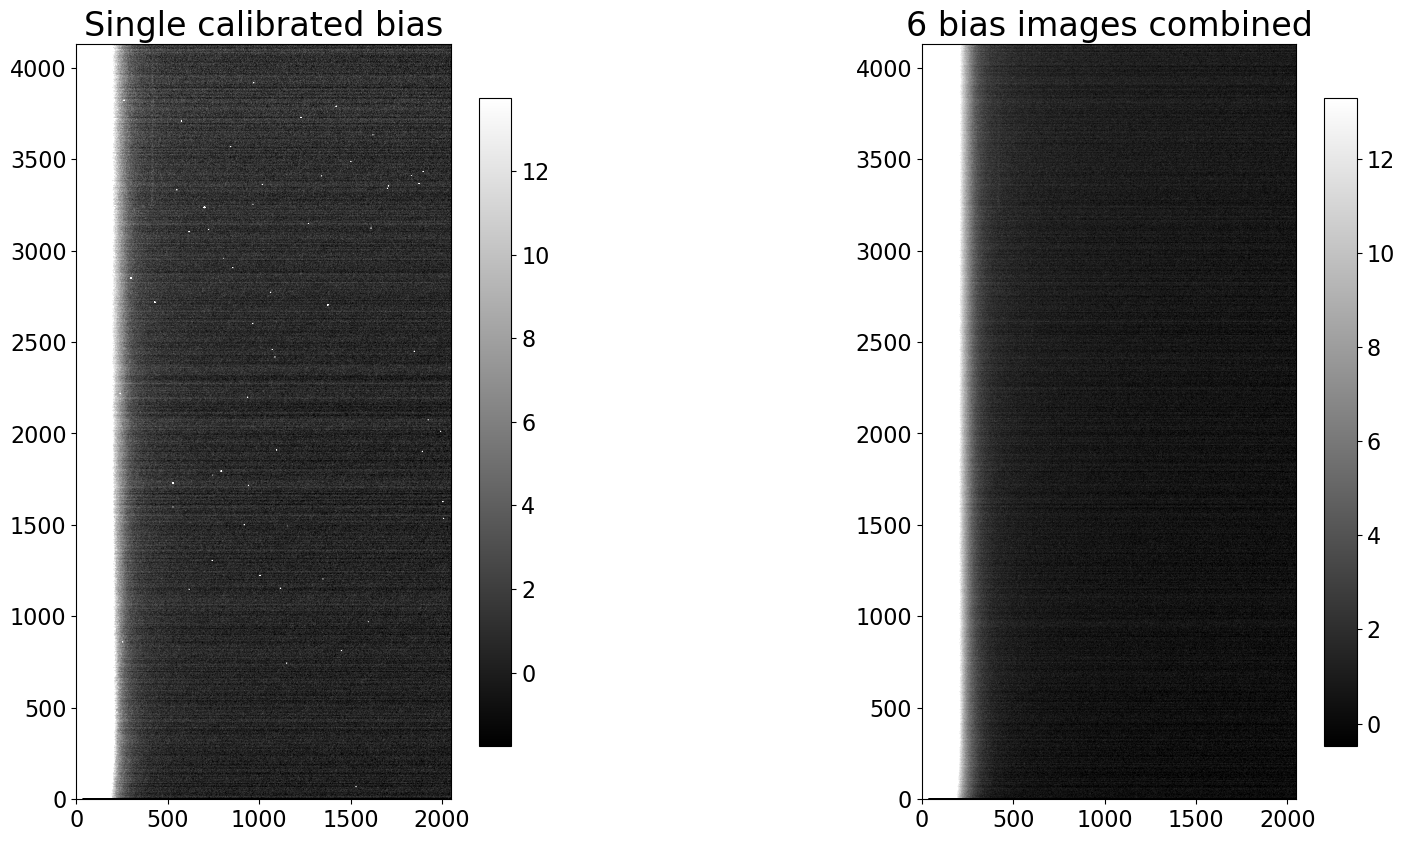

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_biases[0]).data, cmap='gray', ax=ax1, fig=fig, percl=90)
ax1.set_title('Single calibrated bias')
show_image(combined_bias.data, cmap='gray', ax=ax2, fig=fig, percl=90)
ax2.set_title('{} bias images combined'.format(len(calibrated_biases)))

## Example 2: Thermo-electrically cooled camera

The process for combining the images is exactly the same as in example 1. The
only difference is the directory that contains the calibrated bias frames.

In [6]:
calibrated_path = Path('example2-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

The code below:

+ selects the calibrated bias images,
+ combines them using the `combine` function,
+ adds the keyword `COMBINED` to the header so that later calibration steps can
easily identify which bias to use, and
+ writes the file.

In [7]:
calibrated_biases = reduced_images.files_filtered(imagetyp='bias', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combined_bias.meta['combined'] = True

combined_bias.write(calibrated_path / 'combined_bias.fit')

INFO:astropy:splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Result for Example 2

The difference between a single calibrated bias image and the combined bias
image is much clearer in this case.

Text(0.5, 1.0, '10 bias images combined')

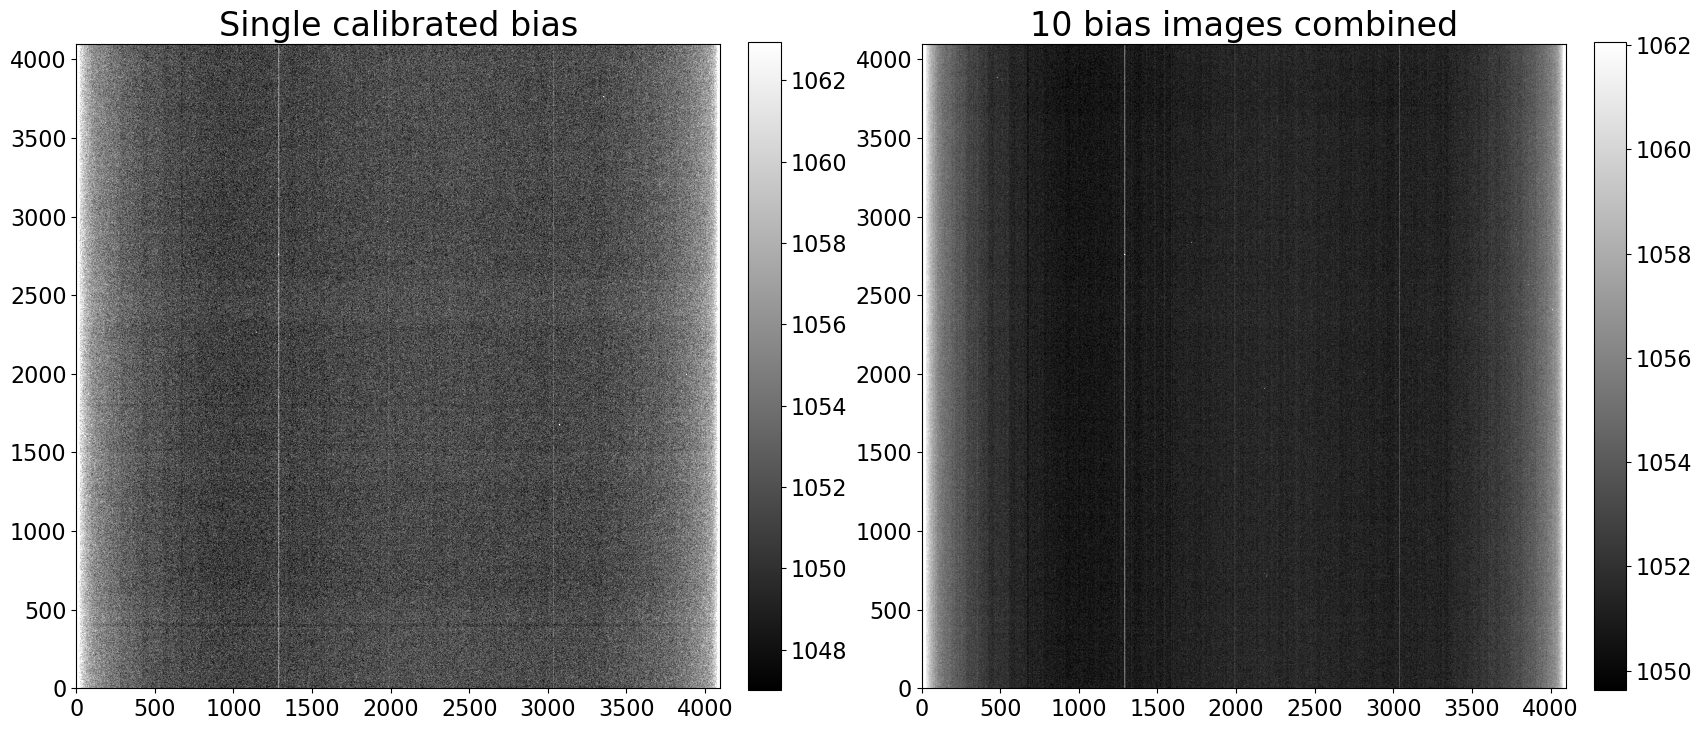

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_biases[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated bias')
show_image(combined_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} bias images combined'.format(len(calibrated_biases)))